In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
import uncrater as uc
from uncrater.utils import cordic2rad, rad2cordic, cordic_add
alpha_to_pdrift = 50e3*4096*16/102.4e6*2*np.pi*1e-6

In [13]:
import json
def read_adc(ch):
    jdata = json.load(open(f'/u/home/anze/Nov21/adc{ch}_output.json'))
    data = np.array(jdata['data'])
    data[data>8192]-=16384
    return data

ewf = [read_adc(ch+1) for ch in range(4)]

def spec(w):
    return np.abs(np.fft.rfft(w)**2)

In [79]:
C = uc.Collection("session_calibrator/cdi_output", cut_to_hello=True)
C.spectra[0]['meta'].base.actual_gain[:], C.spectra[0]['meta'].adc_min

Analyzing 40 files from session_calibrator/cdi_output.


([2, 2, 2, 2], array([ -25, -274, -355, -254]))

Analyzing 40 files from session_calibrator/cdi_output.


(np.float64(0.00013636509733754937), np.float64(0.00013636509733754937))

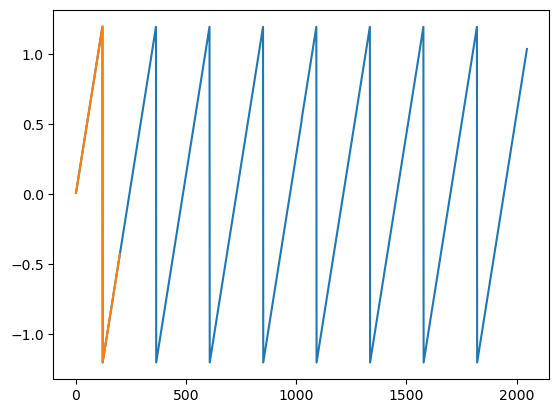

In [80]:


Cd = uc.Collection("session_calibrator/cdi_output", cut_to_hello=True)

plt.plot(C.cd_drift[:]/alpha_to_pdrift,'-')
#plt.plot(np.arange(75), np.arange(75)*0.005)
#plt.plot(C.cd_have_lock[:200]*0.1)
plt.plot(Cd.cd_drift[:200]/alpha_to_pdrift)
C.cd_drift[200:2000].std(),Cd.cd_drift[200:2000].std()

[]

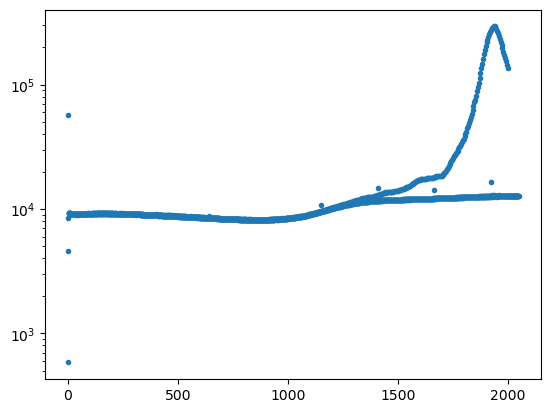

In [53]:
for i in [0,7]:
    plt.plot(np.mean(np.array([sp[2].data[:] for sp in C.spectra[i::8]]),axis=0),'.')
plt.semilogy()

([np.float64(7992.0), np.float64(8009.0)],)

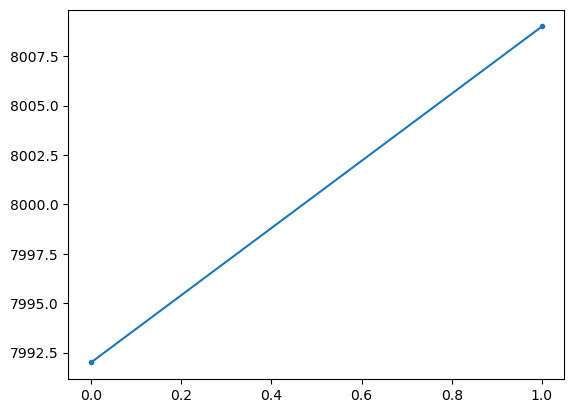

In [54]:
plt.plot([sp[1].data[1201] for sp in C.spectra],'.-')
#plt.plot([sp[2].data[1202] for sp in C.spectra])
#plt.plot([sp[0].data[1203] for sp in C.spectra])

13+(22-13)*25/len(C.spectra)

[sp[1].data[1201] for sp in C.spectra],


Text(0, 0.5, 'Relative drift [ppm]')

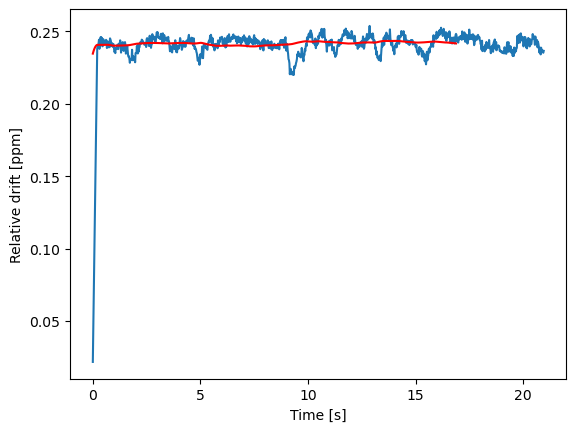

In [55]:
time = np.arange(len(C.cd_drift))*32*16*4096/102.4e6
plt.plot(time,C.cd_drift/alpha_to_pdrift)
avg_drift = np.convolve(C.cd_drift/alpha_to_pdrift, np.ones(200)/200, mode='valid')
avg_time = time[:len(avg_drift)]
plt.plot(avg_time, avg_drift,'r-')
plt.xlabel('Time [s]')  
plt.ylabel('Relative drift [ppm]')
#plt.xlim(0,1)
#plt.plot(Cd.cd_drift[:125]/alpha_to_pdrift)



In [56]:
(C.cd_drift/alpha_to_pdrift)[-5000:].std()/np.sqrt(5000)

np.float64(0.0002035395938991994)

(array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  3.,  2.,
         3.,  9., 12., 18., 39., 25., 41., 53., 46., 74., 61., 59., 66.,
        61., 56., 46., 36., 26., 22., 20., 20., 16.,  2.,  2.,  1.,  3.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]),
 array([-2000.        , -1960.3960396 , -1920.79207921, -1881.18811881,
        -1841.58415842, -1801.98019802, -1762.37623762, -1722.77227723,
        -1683.16831683, -1643.56435644, -1603.96039604, -1564.35643564,
        -1524.75247525, -1485.14851485, -1445.54455446, -1405.94059406,
        -1366.33663366, -1326.73267327, -1287.12871287, -1247.52475248,
        -1207.92079208, -1168.31683168, -1128.71287129, -1089.1089108

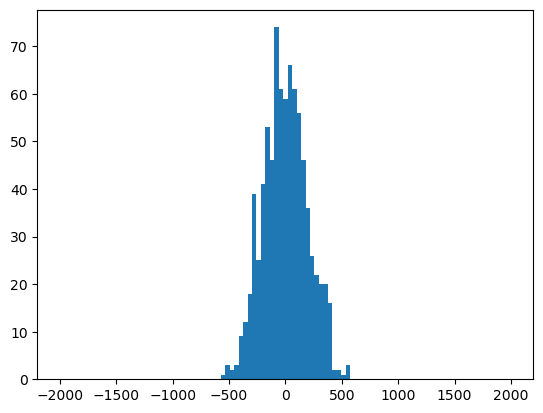

In [57]:
x = C.cd_drift[200:]/np.pi*(1<<30)#/alpha_to_pdrift
d = x[1:]-x[:-1]

plt.hist(d,bins=101,range=(-2000,+2000))
#plt.ylim(0,200)


Text(0.5, 0.98, 'PTOPBOT')

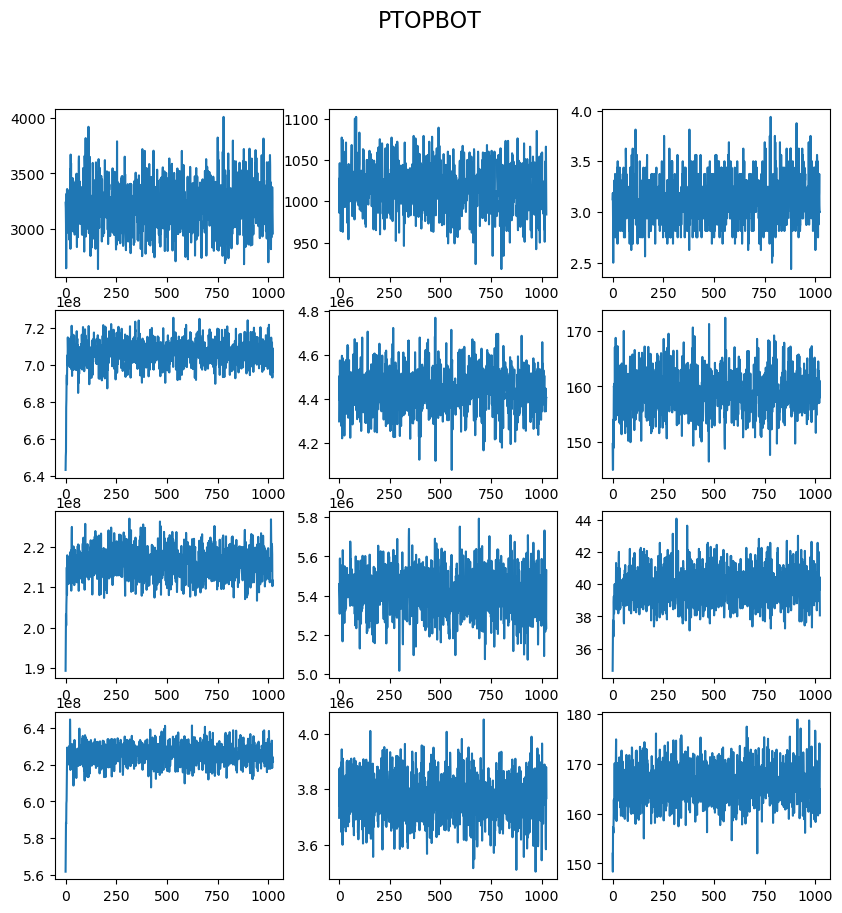

In [58]:
fig, ax = plt.subplots(4,3,figsize=(10,10))
ax[0,0].plot(C.cd_powertop0)
ax[1,0].plot(C.cd_powertop1)
ax[2,0].plot(C.cd_powertop2)
ax[3,0].plot(C.cd_powertop3)

ax[0,1].plot(C.cd_powerbot0)
ax[1,1].plot(C.cd_powerbot1)
ax[2,1].plot(C.cd_powerbot2)
ax[3,1].plot(C.cd_powerbot3)

ax[0,2].plot(C.cd_snr0)
ax[1,2].plot(C.cd_snr1)
ax[2,2].plot(C.cd_snr2)
ax[3,2].plot(C.cd_snr3)
fig.suptitle('PTOPBOT', fontsize=16)


(np.float64(182.61765849359765),
 np.float64(-239984707.32371795),
 np.float64(706291442.1992188),
 np.float64(4440223.0947265625))

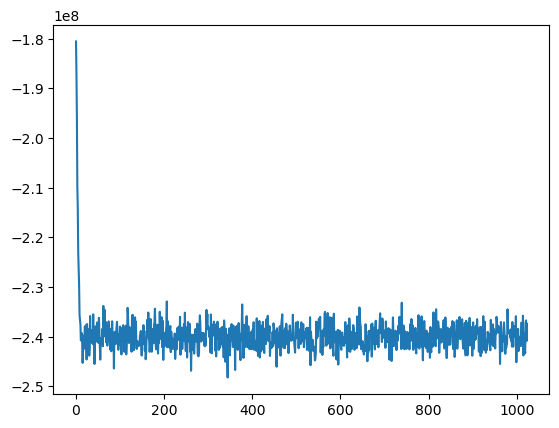

In [59]:
#plt.plot (C.cd_sd2[200:])
plt.plot (C.cd_sd1[:])
C.cd_fd1[400:].std(),C.cd_sd1[400:].mean(), C.cd_powertop1.mean(), C.cd_powerbot1.mean()
#plt.plot (C.cd_snr3[200:])
#plt.plot(C.cd_powerbot3)

np.float64(0.02112031585573164)

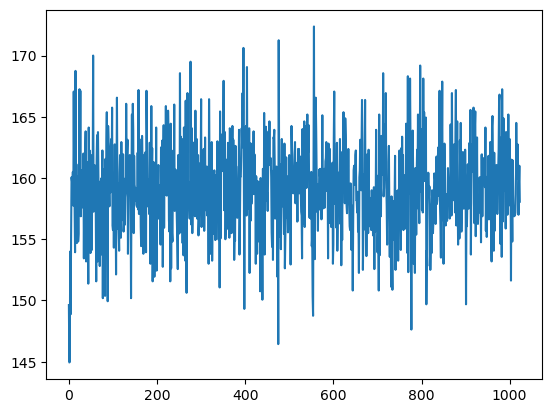

In [60]:
plt.plot(C.cd_snr1)
C.cd_powerbot2[:4000].std()/C.cd_powerbot2[:4000].mean()
#Cd.cd_powertop2[1000:3000].mean()/C.cd_powertop2[1000:3000].mean()

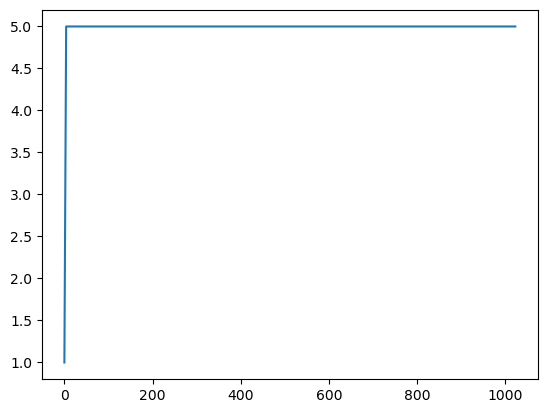

In [61]:
plt.plot(C.cd_have_lock)

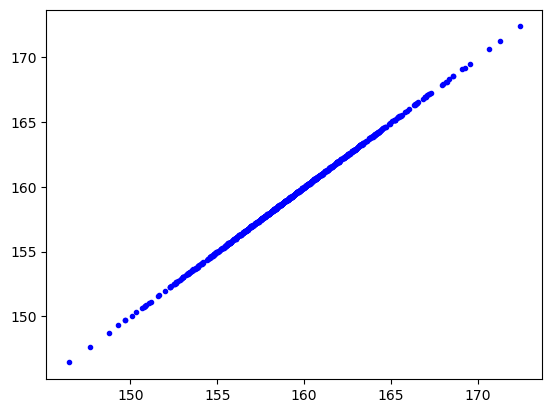

In [62]:
#plt.plot(Cd.cd_snr1[200:])
plt.plot(C.cd_powertop1[200:]/C.cd_powerbot1[200:], C.cd_snr1[200:],'b.')
#plt.plot()


#plt.plot(C.cd_fd2[1200:])
#plt.plot(C.cd_fd3[1200:])


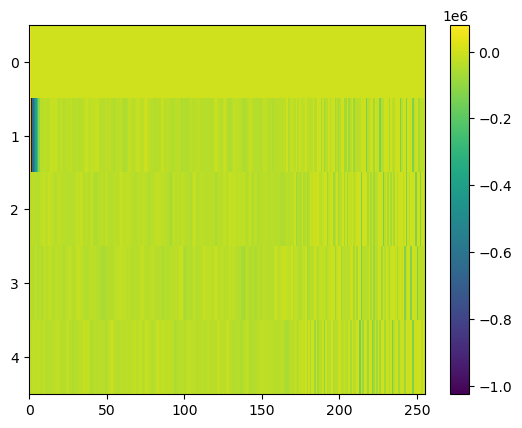

In [63]:
plt.imshow(C.calib_gphase[0:,:256],aspect='auto', interpolation='nearest')#,vmin=-100000, vmax=100000)
plt.colorbar()

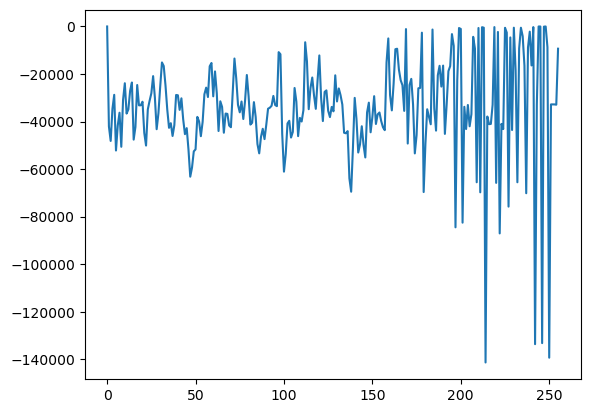

In [64]:
plt.plot(C.calib_gphase[3,:256])

In [65]:
f = C.spectra[0][0].frequency
s0 = C.spectra[0][3].data[:]
s1 = C.spectra[1][3].data[:]
s2 = C.spectra[2][3].data[:]
#plt.plot(f,s2)
for i in [2]:
    plt.plot(f[i::4], s2[i::4],'.', label=str(i))
plt.legend()
#plt.plot(s1,'g.')
#plt.plot(s2,'b.')
#plt.plot(s1*0.001,'r.')

plt.semilogy()

IndexError: list index out of range

Text(0, 0.5, 'power')

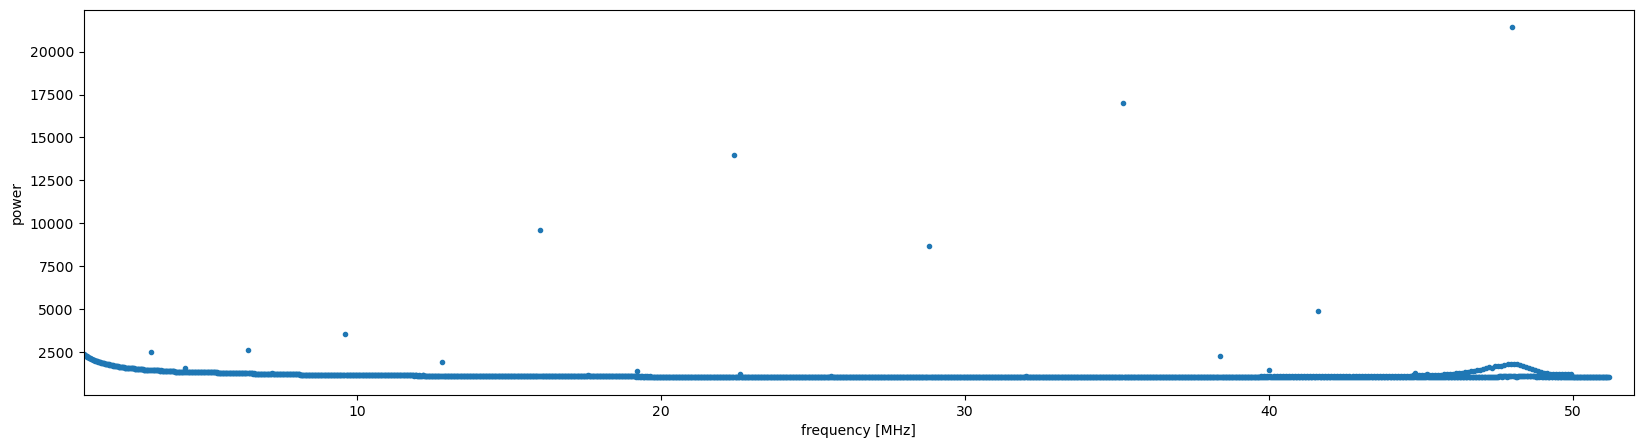

In [66]:

plt.figure(figsize=(20,5))
f = C.spectra[0][0].frequency
for i in [0]:
    s = np.mean([sp[i].data[:] for sp in C.spectra],axis=0)
    plt.plot(f[10:],s[10:],'.')

#plt.plot(f[2::4],s[2::4],'r.',markersize=3)
plt.xlim(1,52)
#plt.ylim(0,1e4)
#plt.ylim(3.0e6,5e6)
#plt.ylim(0.1e3,2e6)
#plt.ylim(3e6,2e7)
#plt.semilogy()
plt.xlabel('frequency [MHz]')
plt.ylabel('power')

Text(0, 0.5, 'power')

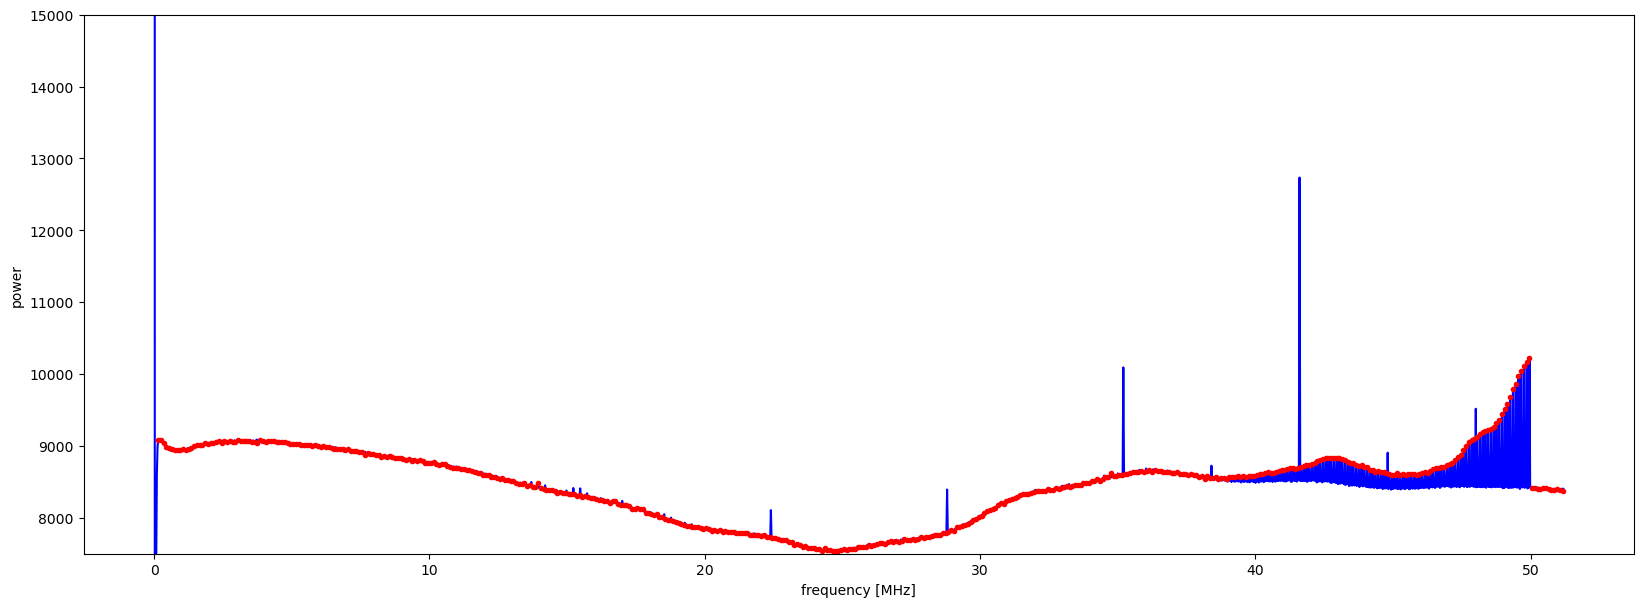

In [84]:

plt.figure(figsize=(20,7))
f = C.spectra[0][0].frequency
s = np.mean([sp[1].data[:] for sp in C.spectra],axis=0)
plt.plot(f,s,'b-')
#plt.plot(f,s*1.03,'k-')
plt.plot(f[2:2048:4],s[2:2048:4],'ro',markersize=3)

#plt.ylim(6e2,2e3)
#plt.xlim(38,52)
#plt.semilogy()
plt.ylim(7500,15e3)
plt.xlabel('frequency [MHz]')
plt.ylabel('power')

Text(0, 0.5, 'power')

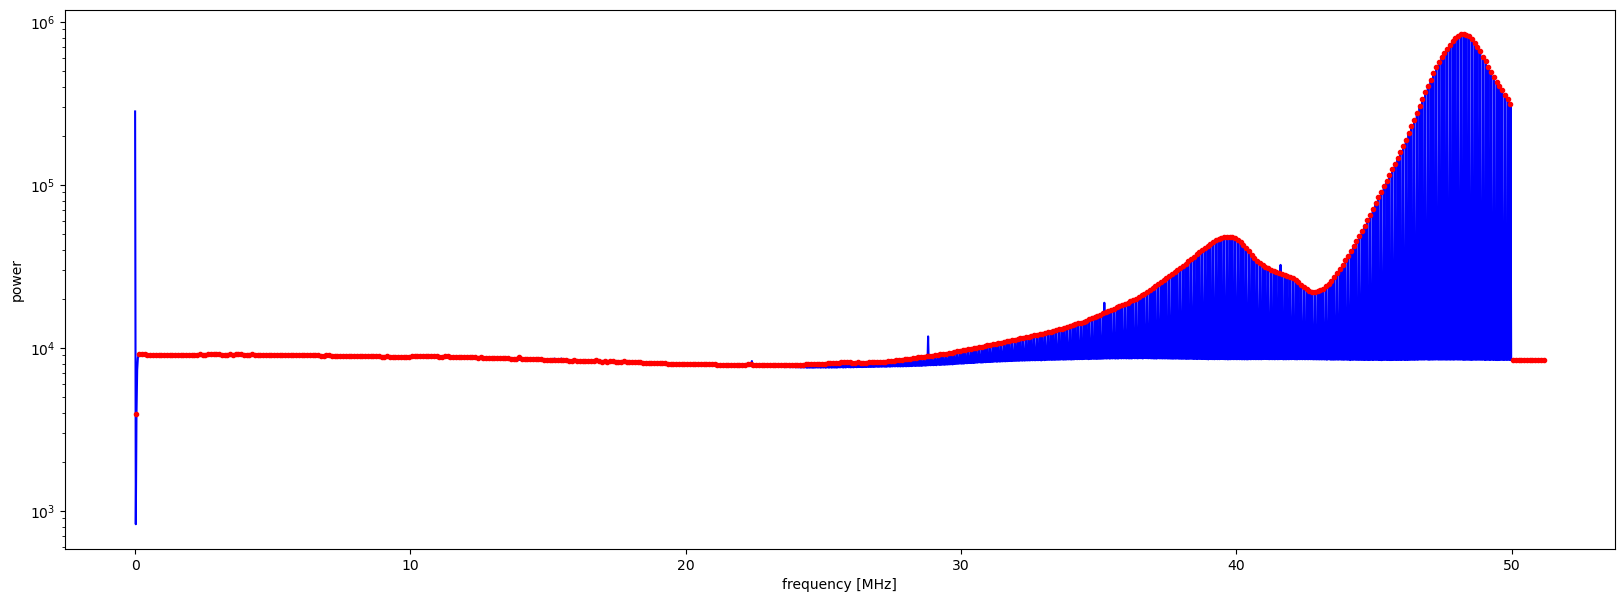

In [68]:
plt.figure(figsize=(20,7))
f = C.spectra[0][0].frequency
s = np.mean([sp[1].data[:] for sp in C.spectra],axis=0)
plt.plot(f,s,'b-')
#plt.plot(f,s*1.03,'k-')
plt.plot(f[2:2048:4],s[2:2048:4],'ro',markersize=3)

#plt.ylim(6e2,2e3)
#plt.xlim(38,52)
plt.semilogy()
plt.xlabel('frequency [MHz]')
plt.ylabel('power')

In [46]:
kcomb = np.arange(512)*4+2

def phase_up (first, second):
    """ Phases up second waveform to the first one """
    Nfft= len(first)*1024
    cross= first*np.conj(second)
    fi = np.zeros(Nfft,complex)
    fi[kcomb] = cross
    xi = np.real(np.fft.fft(fi))
    phi = xi.argmax()*2*np.pi/len(xi)
    second_phased = np.exp(+1j*phi*kcomb)*second
    return second_phased
    

In [47]:
_,wf = np.loadtxt("calibrator_231001.txt").T
wf = np.fft.rfft(np.hstack((wf,wf)))
wf = wf[2::4]

In [48]:


def coherent_addition (C):
    calib_data = []
    for ch in range(4):
        first = np.copy(C.calib_data[-1,ch,:])
        for second in C.calib_data[-1:1:-1,ch,:]:
            second_phased = phase_up(first,second)
            first += second_phased
            #plt.plot(np.angle(first[20:]/second_phased[20:]))
            #plt.plot(second_phased[20:])
            #stop()
        calib_data.append(first)
    calib_data = np.array(calib_data)
    calib_data_wf = []
    for ch in range(4):
        first = np.zeros(512,dtype=complex)
        for second in C.calib_data[1:,ch,:]:
            second_phased = phase_up(wf,second)
            first += second_phased
            #plt.plot(np.angle(first[20:]/second_phased[20:]))
            #plt.plot(second_phased[20:])
            #stop()
        calib_data_wf.append(first)
    calib_data_wf = np.array(calib_data_wf)
    return calib_data, calib_data_wf

calib_data, calib_data_wf = coherent_addition(C)
calib_datad, calib_data_wfd = coherent_addition(Cd)


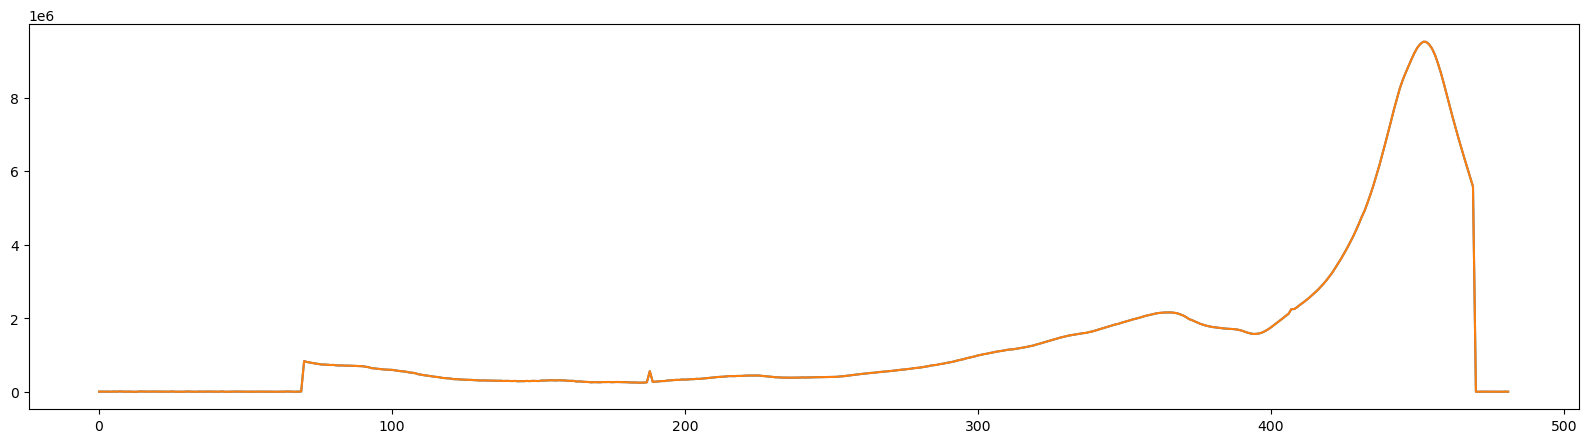

In [49]:
plt.figure(figsize=(20,5))
p1 = np.abs(calib_data[3,30:])
p2 = np.abs(calib_datad[3,30:])
            
#plt.plot((p1-p2)/p1)
#plt.ylim(-0.01,0.01)

plt.plot(p1)
plt.plot(p2)


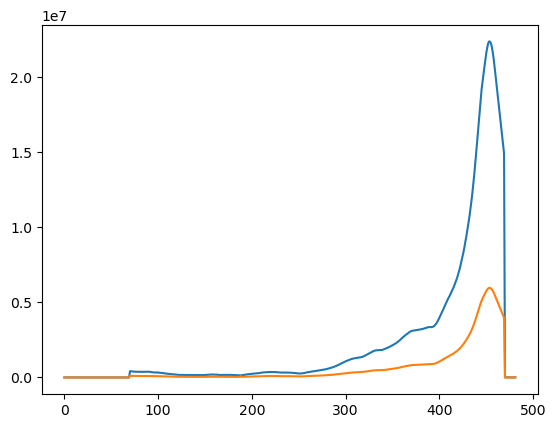

In [50]:
plt.plot(np.abs(calib_data[2,30:]))
plt.plot(np.abs(C.calib_data[1:,2,30:]).mean(axis=0)*4)

[]

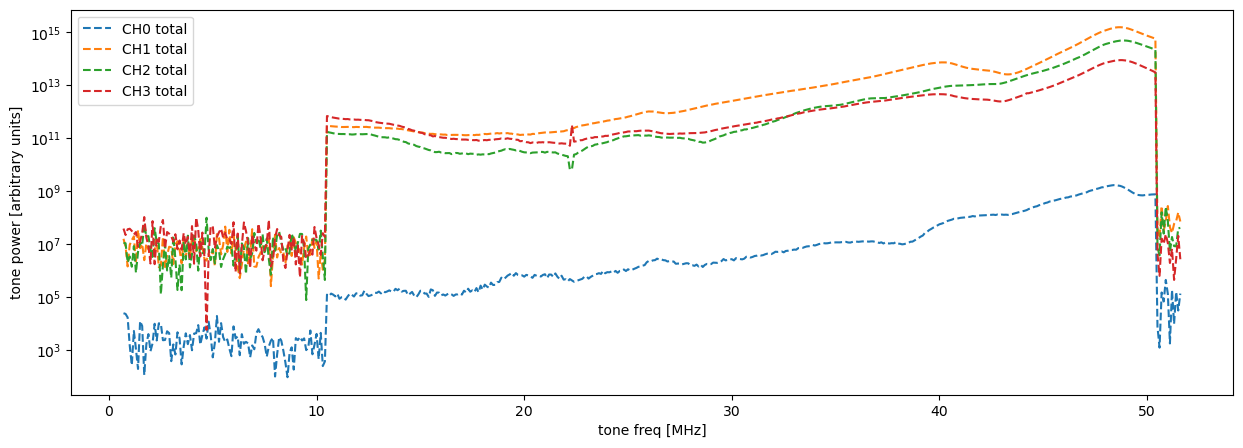

In [51]:
plt.figure(figsize=(15,5))
tfreq=0.5+0.1*np.arange(512)
for ch in range(0,4):
    #plt.plot(tfreq[2:],np.abs(C.calib_data[1:,ch,2:]**2).mean(axis=0),label='CH'+str(ch)+" one int period")
    da = np.abs(calib_data_wf[ch,2:]**2)
    plt.plot(tfreq[2:],da,ls='--',label='CH'+str(ch)+" total")
    #plt.plot(tfreq[2:],np.abs(Cd.calib_data[0:1,ch,2:]**2).mean(axis=0)*4,label='CH'+str(ch))
    #plt.plot(np.abs(Cx.calib_data[ch,1:,:]**1).mean(axis=0), label='CH'+str(ch))

    #plt.plot(np.abs(C.calib_data[ch,1:,100:500]**1).mean(axis=0)/np.abs(Cx.calib_data[ch,1:,100:500]**1).mean(axis=0), label='CH'+str(ch))


plt.legend()
plt.xlabel('tone freq [MHz]')
plt.ylabel('tone power [arbitrary units]')

#i1= np.real(C.calib_data[2,:,400])
#i2=np.imag(C.calib_data[2,:,400])
#i3= np.real(C.calib_data[3,:,400])
#plt.plot(np.imag(C.calib_data[3,:,100]))
#plt.plot(C.calib_data[0,:,400])
#plt.plot(r3**2+i3**2)

plt.semilogy()


In [31]:
#ch = 2
plt.figure(figsize=(20,5))
for i in range(4):
    s = np.mean([sp[ch].data[:] for sp in C.spectra],axis=0)[i::4]
    #c = np.abs(C.calib_data[:,ch,:]**2).mean(axis=0)
    fac = s[400]/c[400]*0.25
    
    plt.plot(s,'.')
    #plt.plot(c*fac,'.c-')
    plt.xlabel('frequency [MHz]')
    plt.ylabel('power [arbitrary units]')
    plt.semilogy()

NameError: name 'c' is not defined

<Figure size 2000x500 with 0 Axes>

In [2044]:
np.abs(C.calib_data[1:,0,0:])


array([[5.85966390e+03, 6.55103809e+02, 1.98587512e+02, ...,
        9.00000000e+00, 1.41421356e+00, 7.28010989e+00],
       [5.84725175e+03, 6.23705059e+02, 2.04413796e+02, ...,
        7.28010989e+00, 1.00000000e+00, 4.47213595e+00],
       [5.95396910e+03, 6.16357851e+02, 2.11589225e+02, ...,
        1.01980390e+01, 2.10237960e+01, 1.02956301e+01],
       ...,
       [5.76670669e+03, 6.07161428e+02, 1.90373317e+02, ...,
        7.81024968e+00, 1.34536240e+01, 6.40312424e+00],
       [5.86066216e+03, 6.20485294e+02, 1.74140748e+02, ...,
        2.30867928e+01, 4.12310563e+00, 7.81024968e+00],
       [5.83272021e+03, 6.11663306e+02, 2.29296751e+02, ...,
        5.09901951e+00, 1.28062485e+01, 5.00000000e+00]], shape=(114, 512))

Text(0, 0.5, 'time index')

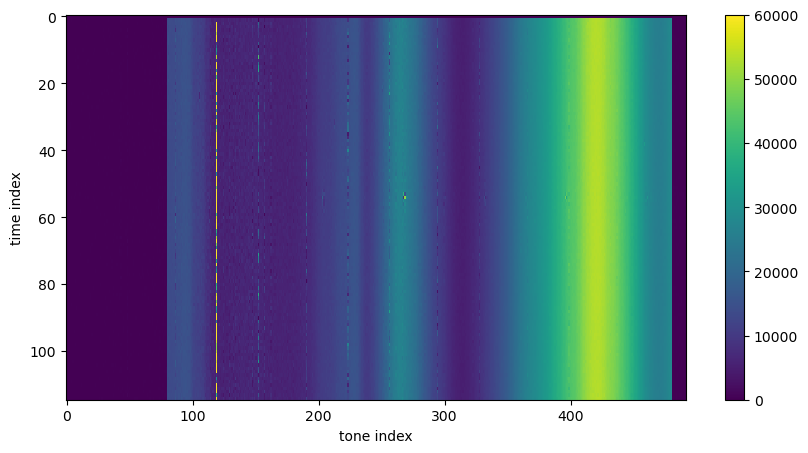

In [2052]:
ch=1
plt.figure(figsize=(10,5))
plt.imshow(np.abs(C.calib_data[0:,ch,20:]),aspect='auto', interpolation='nearest', vmin=0, vmax=60000)
plt.colorbar()
plt.xlabel('tone index')
plt.ylabel('time index')

Text(0.5, 0, 'time index')

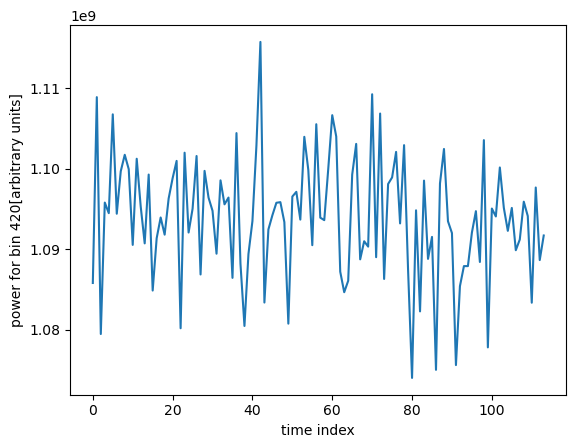

In [2086]:
plt.plot(np.abs(C.calib_data[1:,ch,420]**2))
plt.ylabel('power for bin 420[arbitrary units]')
plt.xlabel('time index')

In [1393]:
pcalib = phase_up(wf,calib_data_wf[1,:])

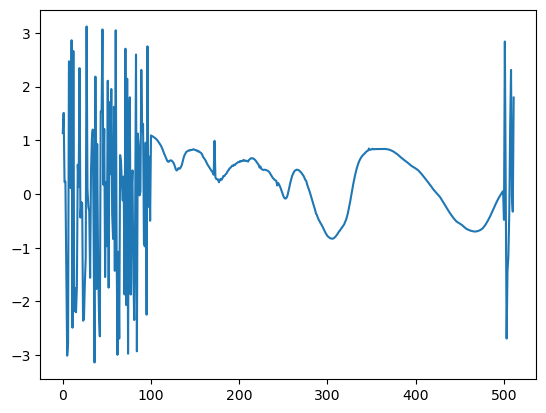

In [1394]:
#plt.plot(np.angle(calib_data[1,:]/wf))
plt.plot(np.angle(pcalib/wf))

#plt.plot(np.imag(pcalib/wf))

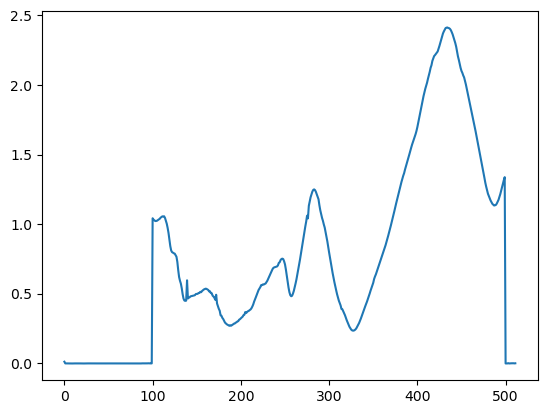

In [1206]:
plt.plot(np.abs(pcalib/wf))

In [85]:
M = C.spectra[1]['meta']
M.base.actual_gain[:],M.base.gain[:], M.adc_max

([2, 2, 2, 2], [2, 2, 2, 2], array([ -16, 1088, 1122, 1684]))